In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker
import seaborn as sns
%load_ext autoreload
%autoreload 2

from settings import *
from url_helpers import analyze_url
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from math import sqrt

In [2]:
figures = conf['aux_dir']+'figure-eight/'
trust_thr = .45

In [3]:
df = pd.read_csv(figures+'tobacco-crowd.csv').rename(columns={'how_do_you_rate_the_scientific_quality_of_this_article': 'non-experts (w/o indicators)'})
df = df[df._trust > trust_thr][['article', 'non-experts (w/o indicators)']]
df.article = df.article.apply(lambda x: x.replace('https://', 'http://'))
print(df.shape)
df_crowd = df.groupby('article').mean()

(85, 2)


In [4]:
df = pd.read_csv(figures+'tobacco-crowd-ind.csv').rename(columns={'how_do_you_rate_the_scientific_quality_of_this_article': 'non-experts (w/ indicators)'})
df = df[df._trust > trust_thr][['article', 'non-experts (w/ indicators)']]
df.article = df.article.apply(lambda x: x.replace('https://', 'http://'))
print(df.shape)
df_crowd_ind = df.groupby('article').mean()

(65, 2)


In [5]:
df1 = pd.read_csv(figures+'tobacco-Andreu.csv').rename(columns={'how_do_you_rate_the_scientific_quality_of_this_article': 'expert1'}).sort_values(by='article')
df2 = pd.read_csv(figures+'tobacco-Aina.csv').rename(columns={'how_do_you_rate_the_scientific_quality_of_this_article': 'expert2'}).sort_values(by='article').drop('article', axis=1)
df_exp = pd.concat([df1,df2], axis=1)[['article', 'expert1', 'expert2']]
df_exp.article = df_exp.article.apply(lambda x: x.replace('https://', 'http://'))
df_exp['diff'] = abs(df_exp['expert1'] - df_exp['expert2'])
df_exp['experts'] = (df_exp['expert1'] + df_exp['expert2'])/2
df_exp = df_exp.set_index('article')
print(cohen_kappa_score(df_exp['expert1'], df_exp['expert2']))


0.09090909090909094


In [6]:
df_sci = pd.read_csv(cache_dir + 'scilens_atc.tsv', sep='\t')
df_sci = df_sci.set_index('article').rename(columns={'scilens':'SciLens'})

In [7]:
df = df_crowd.join(df_exp).join(df_crowd_ind).join(df_sci).reset_index()

In [8]:
print(sqrt(mean_squared_error(df[df['diff']==0]['non-experts (w/o indicators)'], df[df['diff']==0]['experts'])))
print(sqrt(mean_squared_error(df[df['diff']==0]['non-experts (w/ indicators)'], df[df['diff']==0]['experts'])))
print(sqrt(mean_squared_error(df[df['diff']==0]['SciLens'], df[df['diff']==0]['experts'])))
print()
print(sqrt(mean_squared_error(df[df['diff']==1]['non-experts (w/o indicators)'], df[df['diff']==1]['experts'])))
print(sqrt(mean_squared_error(df[df['diff']==1]['non-experts (w/ indicators)'], df[df['diff']==1]['experts'])))
print(sqrt(mean_squared_error(df[df['diff']==1]['SciLens'], df[df['diff']==1]['experts'])))
print()
print(sqrt(mean_squared_error(df[df['diff']>1]['non-experts (w/o indicators)'], df[df['diff']>1]['experts'])))
print(sqrt(mean_squared_error(df[df['diff']>1]['non-experts (w/ indicators)'], df[df['diff']>1]['experts'])))
print(sqrt(mean_squared_error(df[df['diff']>1]['SciLens'], df[df['diff']>1]['experts'])))
print()
print(sqrt(mean_squared_error(df['non-experts (w/o indicators)'], df['experts'])))
print(sqrt(mean_squared_error(df['non-experts (w/ indicators)'], df['experts'])))
print(sqrt(mean_squared_error(df['SciLens'], df['experts'])))

0.8004463040793465
0.45425676257949793
1.4142135623730951

1.2776117041834998
1.1829224638815325
0.7637626158259734

0.4
1.3333333333333333
0.0

1.10073838853744
1.0003471619615085
1.02469507659596


In [9]:
df = df.sort_values(by=['experts', 'diff'])
l = df['article'].apply(lambda x: analyze_url(x)[0]).tolist()
l = [{'winefolly.com':'Wine Folly (blog)',
 'self.com':'Self (blog)',
 'humanprogress.org':'Human Progress',
 'vantagepointrecovery.com':'Vantage Point',
 'marketwatch.com':'Market Watch',
 'fortune.com':'Fortune',
 'esquire.com':'Esquire',
 'thisisinsider.com':'This is Insider',
 'mentalfloss.com':'Mental Floss',
 'uk.businessinsider.com':'Business Insider',
 'healthline.com':'Health Line',
 'illinoispolicy.org':'Illinois Policy',
 'prevention.com':'Prevention',
 'voanews.com':'VOA News',
 'womenshealthmag.com':'Women\'s Health',
 'drugaddictionnow.com':'Drug Addiction Now',
 'weforum.org':'WEForum',
 'outsideonline.com':'Outside Online',
 'nutritionadvance.com':'Nutrition Advance'}.get(o, o) for o in l]
df['article'] = [v + ' (' + str(l[:i].count(v) + 1) + ')' if l.count(v) > 1 else v for i, v in enumerate(l)]
#df['article'] = df.apply(lambda x: x['article']+'*' if x['diff']==0 else x['article']+'**' if x['diff']==1 else x['article']+'***', axis = 1)

In [10]:
df = df[['article', 'non-experts (w/o indicators)', 'non-experts (w/ indicators)', 'experts', 'SciLens']]
df = pd.melt(df, id_vars=['article'], var_name='Rated by', value_name='Quality').rename(columns={'article': 'Outlet'})
df['Quality'] = df['Quality'] + 2

In [11]:
df = df.sort_values(by=['Rated by', 'Quality'], ascending=[True,True])
df = pd.concat([df[(df['Rated by'] == 'experts')],df[~(df['Rated by'] == 'experts')]])

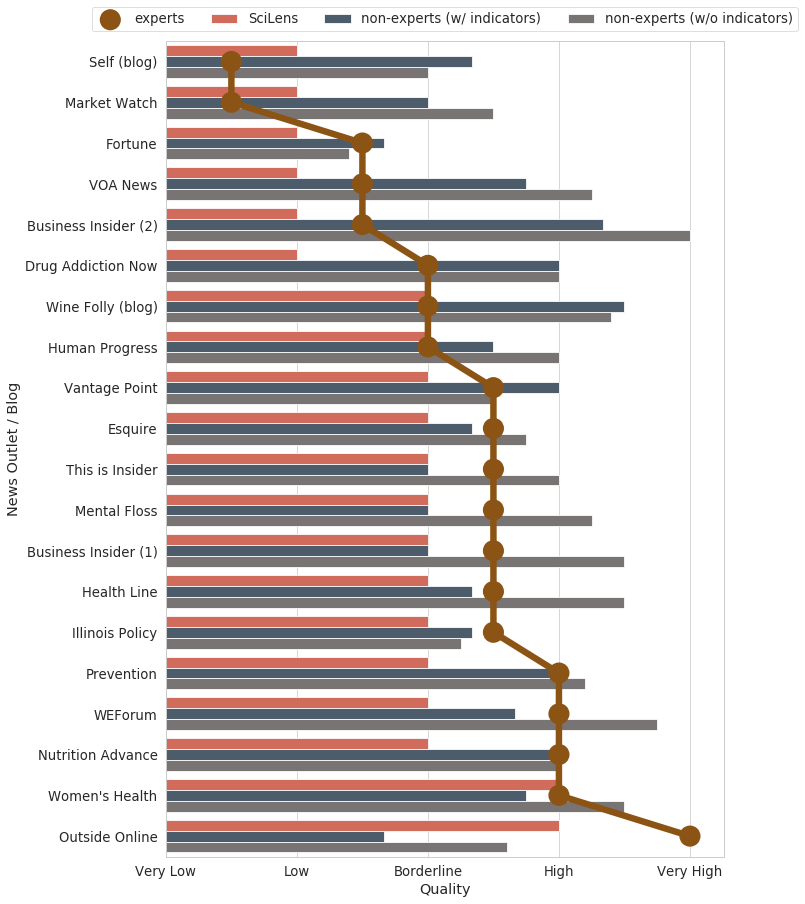

In [13]:
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,15))
ax = sns.pointplot(hue='Rated by', x='Quality', y='Outlet', data=df[(df['Rated by'] == 'experts')], markers='o', palette=['#8c5414'], scale=3, ax=ax)
plt.setp(ax.lines, zorder=100)
plt.setp(ax.collections, zorder=100)
ax = sns.barplot(hue='Rated by', x='Quality', y='Outlet', data=df[~(df['Rated by'] == 'experts')], palette=['#e45d49', '#485c70', '#797373'], ax=ax)
ax.set_xticks(ticks=[0, 1, 2, 3, 4])
ax.set_xticklabels(['Very Low', 'Low', 'Borderline', 'High', 'Very High'])
#plt.xticks(rotation=90)
plt.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.05))
plt.ylabel('News Outlet / Blog')
fig.savefig(figures+'atc.pdf', bbox_inches='tight')